# Training a Simple GPT Model (Colab Version)

In this notebook, we will train a small GPT model on the Daily Dialog dataset using Hugging Face transformers library. This version is specifically adapted for Google Colab and includes all necessary code to train the model.

First, let's install the required packages:

In [1]:
!pip install transformers datasets torch tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Model Configuration

First, let's define our model configuration. Feel free to modify these parameters to experiment with different model sizes and training settings.

In [3]:
class Config:
    # Model architecture parameters
    n_layer = 6          # Number of transformer layers
    n_head = 8           # Number of attention heads
    n_embd = 512        # Embedding dimension
    block_size = 128     # Maximum sequence length
    dropout = 0.1        # Dropout rate

    # Training parameters
    batch_size = 32
    learning_rate = 3e-4
    max_iters = 5000
    eval_interval = 500   # How often to evaluate on validation set
    eval_iters = 200     # How many batches to evaluate on
    device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize configuration
config = Config()

# Print configuration
print(f"Model Configuration:")
print(f"- Number of layers: {config.n_layer}")
print(f"- Number of attention heads: {config.n_head}")
print(f"- Embedding dimension: {config.n_embd}")
print(f"- Maximum sequence length: {config.block_size}")
print(f"- Dropout rate: {config.dropout}")
print(f"\nTraining Configuration:")
print(f"- Batch size: {config.batch_size}")
print(f"- Learning rate: {config.learning_rate}")
print(f"- Maximum iterations: {config.max_iters}")
print(f"- Device: {config.device}")

Model Configuration:
- Number of layers: 6
- Number of attention heads: 8
- Embedding dimension: 512
- Maximum sequence length: 128
- Dropout rate: 0.1

Training Configuration:
- Batch size: 32
- Learning rate: 0.0003
- Maximum iterations: 5000
- Device: cuda


## Data Loading and Preprocessing

Now we'll load and preprocess the Daily Dialog dataset using Hugging Face's datasets library.

In [4]:
def load_and_preprocess_data(config):
    """Load and preprocess the Daily Dialog dataset using HuggingFace."""
    # Load the dataset
    print("Loading dataset...")
    dataset = load_dataset("daily_dialog")

    # Initialize tokenizer
    print("Initializing tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    def tokenize_function(examples):
        """Tokenize a batch of examples."""
        # Join all dialogues with spaces and add EOS token
        texts = [" ".join(d) + tokenizer.eos_token for d in examples["dialog"]]
        return tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=config.block_size,
            return_tensors="pt"
        )

    # Process training data
    print("Processing training data...")
    train_data = dataset["train"].map(
        tokenize_function,
        batched=True,
        batch_size=100,
        remove_columns=dataset["train"].column_names,
        num_proc=4
    )

    # Process validation data
    print("Processing validation data...")
    val_data = dataset["validation"].map(
        tokenize_function,
        batched=True,
        batch_size=100,
        remove_columns=dataset["validation"].column_names,
        num_proc=4
    )

    # Convert to PyTorch datasets
    train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
    val_data.set_format(type="torch", columns=["input_ids", "attention_mask"])

    return train_data, val_data, tokenizer

def get_batch(split, train_data, val_data, config):
    """Get a batch of data for training or validation."""
    data = train_data if split == 'train' else val_data

    # Generate random indices
    ix = torch.randint(len(data), (config.batch_size,))

    # Get the sequences
    batch = data[ix]
    x = batch["input_ids"]

    # Create input-target pairs by shifting
    x = x[:, :-1]
    y = batch["input_ids"][:, 1:]

    # Move to appropriate device
    x, y = x.to(config.device), y.to(config.device)

    return x, y

# Load and preprocess data
train_data, val_data, tokenizer = load_and_preprocess_data(config)

print(f"\nDataset Statistics:")
print(f"- Training examples: {len(train_data)}")
print(f"- Validation examples: {len(val_data)}")
print(f"- Vocabulary size: {len(tokenizer)}")

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Initializing tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Processing training data...


Map (num_proc=4):   0%|          | 0/11118 [00:00<?, ? examples/s]

Processing validation data...


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]


Dataset Statistics:
- Training examples: 11118
- Validation examples: 1000
- Vocabulary size: 50257


## Model Implementation

Let's implement our GPT model using HuggingFace's transformers library.

In [5]:
class GPT(nn.Module):
    """GPT Language Model using HuggingFace's GPT2"""

    def __init__(self, config):
        super().__init__()
        self.config = GPT2Config(
            n_layer=config.n_layer,
            n_head=config.n_head,
            n_embd=config.n_embd,
            vocab_size=50257,  # GPT-2 vocabulary size
            n_positions=config.block_size,
            n_ctx=config.block_size,
            dropout=config.dropout
        )
        self.transformer = GPT2LMHeadModel(self.config)
        self.block_size = config.block_size

    def forward(self, idx, targets=None):
        # Forward pass through GPT-2
        outputs = self.transformer(
            idx,
            labels=targets if targets is not None else None,
            return_dict=True
        )

        if targets is not None:
            return outputs.logits, outputs.loss
        else:
            return outputs.logits, None

@torch.no_grad()
def estimate_loss(model, train_data, val_data, config):
    """Estimate loss on train and validation sets"""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(config.eval_iters)
        for k in range(config.eval_iters):
            X, Y = get_batch(split, train_data, val_data, config)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

@torch.no_grad()
def generate(model, tokenizer, prompt, max_tokens=50, temperature=1.0, top_k=None, config=None):
    """Generate text from a prompt."""
    # Encode the prompt
    encoded = tokenizer.encode(prompt, return_tensors='pt').to(config.device)

    # Generate using HuggingFace's built-in generation
    output_sequences = model.transformer.generate(
        encoded,
        max_length=len(encoded[0]) + max_tokens,
        temperature=temperature,
        top_k=top_k if top_k is not None else 50,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    # Decode the generated text
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return generated_text

# Initialize the model
model = GPT(config)
model.to(config.device)

# Print model summary
print("Model Architecture:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"- Total parameters: {total_params:,}")
print(f"- Trainable parameters: {trainable_params:,}")

Model Architecture:
- Total parameters: 44,712,448
- Trainable parameters: 44,712,448


## Training Loop

Now we'll train the model, tracking both training and validation loss.

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step 0: train loss 8.7130, val loss 8.9164
Step 500: train loss 3.6026, val loss 3.8663
Step 1000: train loss 3.2095, val loss 3.6123
Step 1500: train loss 2.9511, val loss 3.5286
Step 2000: train loss 2.6612, val loss 3.4266
Step 2500: train loss 2.3717, val loss 3.4640
Step 3000: train loss 2.1072, val loss 3.4956
Step 3500: train loss 1.8089, val loss 3.5237
Step 4000: train loss 1.5353, val loss 3.5613
Step 4500: train loss 1.3173, val loss 3.6109


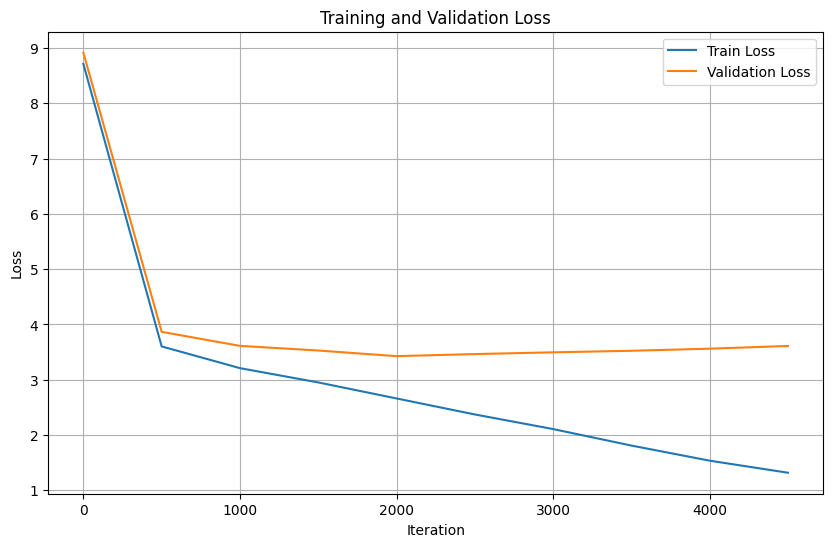

In [6]:
# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# Lists to store losses for plotting
train_losses = []
val_losses = []
iterations = []

# Training loop
for iter in tqdm(range(config.max_iters), desc="Training"):
    # Sample a batch of data
    xb, yb = get_batch('train', train_data, val_data, config)

    # Forward pass
    logits, loss = model(xb, yb)

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Evaluate the model
    if iter % config.eval_interval == 0:
        losses = estimate_loss(model, train_data, val_data, config)
        print(f"Step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Store losses for plotting
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        iterations.append(iter)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_losses, label='Train Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Text Generation

Let's test our trained model by generating some text:

In [7]:
# Test text generation with different prompts and temperatures
prompts = [
    "Hello, how are you",
    "I'm planning to",
    "The weather is"
]

temperatures = [0.7, 1.0, 1.2]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    for temp in temperatures:
        generated = generate(model, tokenizer, prompt, max_tokens=50, temperature=temp, config=config)
        print(f"\nTemperature {temp}:")
        print(generated)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Prompt: Hello, how are you

Temperature 0.7:
Hello, how are you  I here  you . you  Fine .  Do have identification ?  Yes And you traveler checks check  Yes We have traveler checks  No Yes We them  OK  you . you checks cash  Really  And want send account 

Temperature 1.0:
Hello, how are you ?  I started a weeks and'm .'m little about .'d to into a box .'d to if'll of few with about the price  How are ?  H , , , guess we to get better . can .'ve got new .

Temperature 1.2:
Hello, how are you ?  I from---ed . can tell a .'m see your by name  Eu .  Hi see identification  Yes do want apply  Yes Do have membership with- ?  These . are-- .  Can have credit

Prompt: I'm planning to

Temperature 0.7:
I'm planning to my .  Okay I take .

Temperature 1.0:
I'm planning to some----ina to--ed .  If'll you your will the be to you to us  I assure it will you you done .  Don be ,'d get choice you done good .

Temperature 1.2:
I'm planning to for these .  If'd stay so'll to honest you  Can stay a lon

## Save the Model

Finally, let's save our trained model and download it from Colab:

In [8]:
# Create a directory for the model
import os
os.makedirs('models', exist_ok=True)

# Save the model
model_path = 'models/gpt_model'
model.transformer.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved to {model_path}")

# For Colab: Download the model
from google.colab import files
!zip -r models.zip models/
files.download('models.zip')

Model and tokenizer saved to models/gpt_model
  adding: models/ (stored 0%)
  adding: models/gpt_model/ (stored 0%)
  adding: models/gpt_model/config.json (deflated 52%)
  adding: models/gpt_model/special_tokens_map.json (deflated 74%)
  adding: models/gpt_model/merges.txt (deflated 53%)
  adding: models/gpt_model/tokenizer_config.json (deflated 56%)
  adding: models/gpt_model/model.safetensors (deflated 7%)
  adding: models/gpt_model/generation_config.json (deflated 24%)
  adding: models/gpt_model/vocab.json (deflated 68%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>